<a href="https://colab.research.google.com/github/norhum/deep_learning/blob/main/MNIST1-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [2]:
# construct the MNIST dataset

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, drop_last=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 33462441.21it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1215001.94it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 9243755.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2507308.34it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# build various necessary models

class SimpleNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.ff1 = nn.Linear(28*28, 256)
    self.ff2 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = torch.relu(self.ff1(x))
    x = self.ff2(x)
    return x

class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn1 = nn.Conv2d(1, 3, (3,3), padding=1) #batch,3,28,28
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #batch,3,14,14
    self.cnn2 = nn.Conv2d(3, 5, (3,3), padding=1) #batch,5,14,14
    self.fc = nn.Linear(5*14*14, 10) #batch, 10

  def forward(self, x):
    x = self.pool(F.relu(self.cnn1(x)))
    x = F.relu(self.cnn2(x))
    x = x.view(-1, 5*14*14)
    x = self.fc(x)
    return x

In [4]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [5]:
# train

epochs = 5
for epoch in range(epochs):
  running_loss = 0.0
  for images, labels in trainloader:
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    actual_loss = running_loss/len(trainloader)

  print(f'Epoch: {epoch+1}, Loss: {actual_loss}')

Epoch: 1, Loss: 0.26690122907188113
Epoch: 2, Loss: 0.11388850833707774
Epoch: 3, Loss: 0.09146622417935964
Epoch: 4, Loss: 0.08121549192042733
Epoch: 5, Loss: 0.07174837783380564


In [6]:
correct = 0
total = 0
with torch.no_grad():
  for images, labels in testloader:
    outputs = model(images)
    _, indices = torch.max(outputs, dim=1)
    correct += (indices == labels).sum().item()
    total += labels.shape[0]

print(f'test data accuracy: {correct/total:.4f}')

test data accuracy: 0.9789


In [7]:
import matplotlib.pyplot as plt

intelligible = []
answers = []
model_predictions = []

with torch.no_grad():
  for images, labels in testloader:
    outputs = model(images)
    _, indices = torch.max(outputs, dim=1)
    incorrect = labels != indices

    if sum(incorrect) != 0:
      answer = labels[incorrect]
      model_prediction = indices[incorrect]

      answers.append(answer)
      model_predictions.append(model_prediction)
      intelligible.append(images[incorrect])

intelligible = torch.cat(intelligible)
answers = torch.cat(answers)
model_predictions = torch.cat(model_predictions)

print(intelligible.shape, answers.shape, model_predictions.shape)

torch.Size([211, 1, 28, 28]) torch.Size([211]) torch.Size([211])


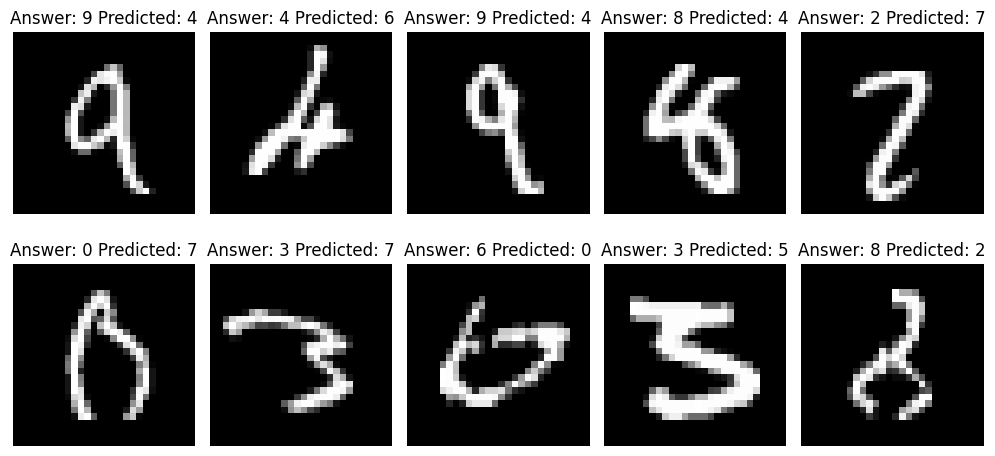

In [8]:
plt.figure(figsize=(10, 5))

# Plot the first 10 images
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid, 1-based index
    plt.imshow(intelligible[i][0], cmap='gray')  # Display the image
    plt.title(f'Answer: {answers[i]} Predicted: {model_predictions[i]}')  # Show the label
    plt.axis('off')  # Hide the axes

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
# build a checkpoint
checkpoint = {
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": actual_loss,
}
torch.save(checkpoint, "checkpoint.pth")

In [19]:
loaded_checkpoint = torch.load("checkpoint.pth")
print(loaded_checkpoint.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


<ipython-input-19-31e90998f733>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load("checkpoint.pth")


In [29]:
# train another model with the pre-existing model weights
model2 = SimpleCNN()
model2.load_state_dict(loaded_checkpoint['model_state_dict'])
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
optimizer2.load_state_dict(loaded_checkpoint['optimizer_state_dict'])
epoch2 = loaded_checkpoint['epoch']

for key in model2.state_dict():
  if torch.all(model.state_dict()[key] == model2.state_dict()[key]):
    print(f'{key} matches')
  else:
    print(f"{key} doesn't match")

for epoch in range(epochs):
  running_loss = 0.0
  for images, labels in trainloader:
    outputs = model2(images)
    loss = criterion(outputs, labels)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()

    running_loss += loss.item()
    actual_loss = running_loss/len(trainloader)

  print(f'Epoch: {epoch+epoch2+1}, Loss: {actual_loss}')


cnn1.weight matches
cnn1.bias matches
cnn2.weight matches
cnn2.bias matches
fc.weight matches
fc.bias matches
Epoch: 5, Loss: 0.06766068123791888
Epoch: 6, Loss: 0.06310790288684494
Epoch: 7, Loss: 0.05800674252685163
Epoch: 8, Loss: 0.05589606323957308
Epoch: 9, Loss: 0.05376157179060357
